https://dotsnlines.tistory.com/958

In [1]:
!pip install pykrx

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pykrx import stock
import sqlite3

df_kos = stock.get_index_fundamental('20000101','20240715', '1001')
con = sqlite3.connect('krx_data.db')
df_kos.to_sql('kospi_index', con=con, if_exists='replace')

print(df_kos)

                 종가   등락률    PER   PBR  배당수익률
날짜                                           
2000-01-04  1059.04  3.01   0.00  0.00   0.63
2000-01-05   986.31 -6.87   0.00  0.00   0.68
2000-01-06   960.79 -2.59   0.00  0.00   0.70
2000-01-07   948.65 -1.26   0.00  0.00   0.71
2000-01-10   987.24  4.07   0.00  0.00   0.68
...             ...   ...    ...   ...    ...
2024-07-09  2867.38  0.34  19.23  1.03   1.73
2024-07-10  2867.99  0.02  19.24  1.03   1.73
2024-07-11  2891.35  0.81  19.40  1.03   1.72
2024-07-12  2857.00 -1.19  19.18  1.02   1.74
2024-07-15  2860.92  0.14   0.00  0.00   0.00

[6055 rows x 5 columns]


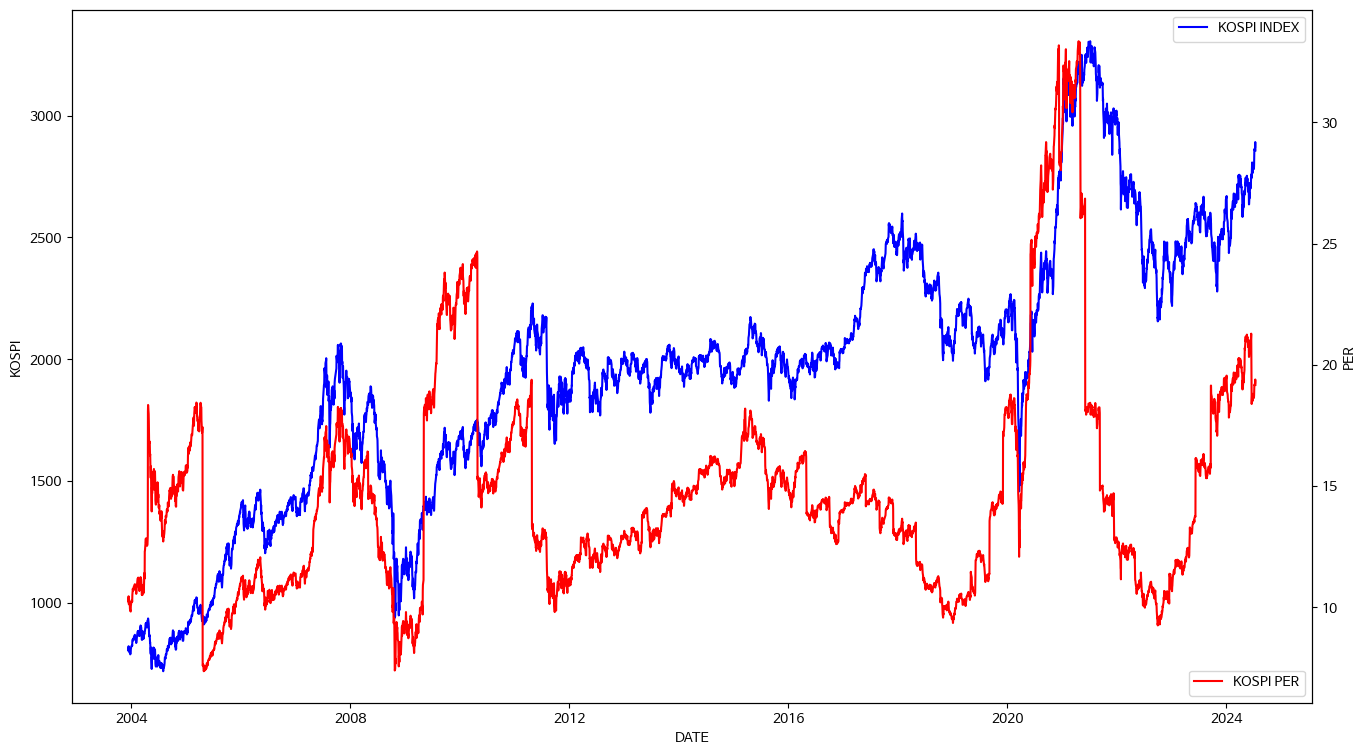

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

con = sqlite3.connect("krx_data.db")
df_kos = pd.read_sql("SELECT 날짜, 종가, 등락률, PER, PBR FROM kospi_index WHERE 날짜 > '2003-12-12' AND 날짜 < '2024-07-15'", con)

df_kos['날짜'] = pd.to_datetime(df_kos['날짜'])
# df_kos['날짜'] = df_kos['날짜'].dt.strftime('%Y%m%d')
df_kos = df_kos.set_index('날짜')

plt.rcParams['figure.figsize'] = (16, 9)

fig, ax1 = plt.subplots()
ax1.set_xlabel('DATE')
ax1.set_ylabel('KOSPI')
ax1.plot(df_kos.index, df_kos['종가'], color='blue', label='KOSPI INDEX')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('PER')
ax2.plot(df_kos.index, df_kos['PER'], color='red', label='KOSPI PER')
ax2.legend(loc='lower right')

plt.show()